# RAG Safety

Disclaimer: This project digressed into OOD (out-of-domain) query detection instead. However, as long as you collect actual negative examples, there is no need to modify any part except data processing.

Datasets (16):
- Internal: COVID, Substance
- MSMARCO: biomedical, music, film, finance, law, computing
- Stackoverflow: history, crypto, chess, cooking, astronomy, fitness, anime, literature

Methods (6):
- E-family: E-ball, E-cube (same edge), E-cube (different edges)
- Linear: LogReg, SVM
- Clustering: GMM 

Ablation Study (based on digressed topic): 
- 3 different PC projections using different bi-encoders (NO statistical significance via 2-sample Kolmogorov-Smirnov test)
    - MPNet (main)
    - DistilBERT
    - DistilROBERTa
- 2 different feature computations (NO visible difference in performance)
    - Projection of Query embeddings on Doc PCs
    - Distance between Query embeddings and Doc PCs
- Whether to sort PCs based on individual performance (NO visible difference in performance, which does NOT make sense)
    - Sort PC by explained variance (i.e., default order)
    - Sort PC by individual performace on dataset
- Performance vs #PCs
- Performance vs Radius (E-family only)
- Optimal hyperparameters per dataset (E-family only)

# Prep

In [1]:
import json
import copy
import cv2
import os
import warnings
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import EpsilonCubeNeighborsClassifier
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.svm import SVC
from scipy.stats import mode, ks_2samp
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from datasets import load_dataset
from datasets.utils.logging import disable_progress_bar

SEED = 2
np.random.seed(SEED)
warnings.filterwarnings('ignore')
disable_progress_bar()

In [2]:
# for iteration
colors = ['r','g','b','y','c','m','k','orange','brown','purple']
model_list = ['all-mpnet-base-v2', 'all-distilroberta-v1', 'multi-qa-distilbert-cos-v1']
tag_list = ["covid", "drugs", "biomedical", "music", "film", "finance", "law", "computing", "history", "crypto", "chess", "cooking", "astronomy", "fitness", "anime", "literature"]
metric_list = ['proj', 'dist']
tag_to_ind = {v:i for i,v in enumerate(tag_list)}
model_to_ind = {v:i for i,v in enumerate(model_list)}
msmarco_tags = tag_list[2:8]
stackexchange_tags = tag_list[8:]

# for optimal hyperparameter iteration
# lowest std: 0.005
# highest std: 0.2
radiuses = [0.01] + list(map(lambda x: x/1000, range(0, 301, 20)))[1:]
n_pcs_bundle = list(range(1,20))+list(range(20,180,20))

# methods
clf_dict = {
    "eball": RadiusNeighborsClassifier,
    "ecube": EpsilonCubeNeighborsClassifier,
    "erect": EpsilonCubeNeighborsClassifier,
    "logreg": LogisticRegression,
    "svm": SVC,
    "gmm": GaussianMixture
}
clf_args_dict = {
    "eball": {"outlier_label": 0},
    "ecube": {"outlier_label": 0},
    "erect": {"outlier_label": 0},
    "logreg": {},
    "svm": {"kernel": "linear"},
    "gmm": {"n_components": 2, "random_state": SEED},
}

# Load

Before running the code,
1. Create a `data` folder in the project dir.
2. Download `response_db.csv` and `Substance_Use_and_Recovery_FAQ.csv`.
3. Follow https://github.com/microsoft/MSMARCO-Question-Answering to download MSMARCO SQUAD Q&A json datasets (train, test, dev per dataset)

In [3]:
def load_local():
    """load COVID and Substance data

    Returns:
        (list(df)): a list of 2 dfs (COVID, Substance)
    """
    return [
        pd.read_csv(r'data\response_db.csv',encoding='unicode_escape').drop_duplicates(['user_kp','system_kp']).reset_index(drop=True),
        pd.read_csv(r'data\Substance_Use_and_Recovery_FAQ.csv')
    ]

def json_to_df(path):
    """convert given MSMARCO json dataset to df

    Args:
        path (str): path to each json file

    Returns:
        (df): dataframe per MSMARCO dataset
    """
    d = json.load(open(path,'r'))['data']
    docs = [item['paragraphs'][0]['context'] for item in d]
    queries = [item['paragraphs'][0]['qas'][0]['question'] for item in d]
    return pd.DataFrame({'query': queries, 'doc': docs})

def load_msmarco(id):
    """load given MSMARCO dataset into df

    Args:
        id (str): domain name per stackexchange dataset

    Returns:
        (df): dataframe per stackexchange dataset
    """
    return pd.concat([
        json_to_df(rf'data\msmarco\squad.{id}.train.json'),
        json_to_df(rf'data\msmarco\squad.{id}.dev.json'),
        json_to_df(rf'data\msmarco\squad.{id}.test.json')
    ]).reset_index(drop=True)

def load_stackexchange(id):
    """load given stackexchange dataset into df

    Args:
        id (str): domain name per stackexchange dataset

    Returns:
        (df): dataframe per stackexchange dataset
    """
    return load_dataset("flax-sentence-embeddings/stackexchange_title_best_voted_answer_jsonl", id, split="train")

def get_q_d():
    """get queries and docs

    Returns:
        queries (list(list)): a list of lists of queries for all domains
        docs (list(list)): a list of lists of docs for all domains
    """
    # load data
    dfs = load_local()
    dfs += [load_msmarco(tag) for tag in msmarco_tags]
    dfs += [load_stackexchange(tag) for tag in stackexchange_tags]

    # get queries
    queries = [
        dfs[0]['user_kp'].tolist(),
        dfs[1]['question'].tolist()
    ]
    queries += [df['query'].tolist() for df in dfs[2:8]]
    queries += [df['title_body'] for df in dfs[8:]]

    # get docs
    docs = [
        dfs[0]['system_kp'].tolist(),
        dfs[1]['relevant answer'].tolist()
    ]
    docs += [df['doc'].tolist() for df in dfs[2:8]]
    docs += [df['upvoted_answer'] for df in dfs[8:]]

    return queries, docs

def get_pca(doc_embs):
    """get PCA for the given dataset

    Args:
        doc_embs (ndarray): doc embeddings per dataset

    Returns:
        pca: PCA object after fitting
    """
    doc_embeddings = StandardScaler().fit_transform(doc_embs)
    pca = PCA()
    pca.fit(doc_embeddings)
    return pca

def get_feats(a, b, metric):
    """get features between a and b

    Args:
        a (ndarray): query embeddings
        b (ndarray): PCs for a specific domain of doc embeddings
        metric (str): proj = projections; dist = distances

    Returns:
        X (ndarray): features
    """
    if metric == 'proj':
        return np.dot(a,b.T)
    if metric == 'dist':
        X = np.zeros((len(a),len(b)))
        for i in range(len(a)):
            for j in range(len(b)):
                X[i][j] = euclidean(a[i],b[j])
        return X

###### EDIT ######
def get_labels():
    pass

def get_train_test_split():
    pass

# THIS SECTION IS UNNECESSARY IF YOU ALREADY HAVE POSITIVE/NEGATIVE QUERIES LABELED. PLEASE MAKE YOUR OWN TRAIN-TEST SPLIT INSTEAD!!!
# def sample(arr, size):
#     return arr[np.random.choice(list(range(arr.shape[0])), size=size, replace=False),:]

# def get_subset(data, model, tag):
#     i,j = model_to_ind[model], tag_to_ind[tag]
#     X = data[i].copy()
#     X_pos = X.pop(j)
#     X_neg = sample(np.vstack(X), len(X_pos))
#     if j in (0,1): X_neg = X_neg[:,:X_pos.shape[1]]
#     X = np.vstack([X_pos, X_neg])
#     y = np.vstack([np.ones((len(X_pos),1)), np.zeros((len(X_neg),1))])
#     return X,y

# def get_train_test_split_inds(n_samples, test_size=0.1):
#     inds = np.arange(n_samples)
#     train_inds_pos, test_inds_pos, _, _ = train_test_split(inds, inds, test_size=test_size, random_state=SEED)
#     train_inds_neg, test_inds_neg, _, _ = train_test_split(inds, inds, test_size=test_size, random_state=SEED)
#     train_inds, test_inds = np.append(train_inds_pos, train_inds_neg+n_samples), np.append(test_inds_pos, test_inds_neg+n_samples)
#     np.random.shuffle(train_inds)
#     np.random.shuffle(test_inds)
#     return train_inds, test_inds

# def get_train_test_data(data, model, tag, in_sample=False):
#     i,j = model_to_ind[model], tag_to_ind[tag]
#     X,y = data[i][j][:,:-1], data[i][j][:,-1]
#     if in_sample:
#         X_train, X_test, y_train, y_test = X,X,y,y
#     else:
#         train_inds, test_inds = get_train_test_split_inds(len(y)//2, test_size=0.1)
#         X_train, X_test, y_train, y_test = X[train_inds], X[test_inds], y[train_inds], y[test_inds]
#     return X_train, X_test, y_train, y_test

In [31]:
# get embeddings
queries, docs = get_q_d()
d_embs = [[SentenceTransformer(model, device='cuda').encode(doc) for doc in docs] for model in model_list]
q_embs = [[SentenceTransformer(model, device='cuda').encode(query) for query in queries] for model in model_list]
for i,model in enumerate(model_list):
    for j,d_emb in enumerate(d_embs[i]):
        np.save(fr"embeddings\d_emb_{model}_{j}.npy", d_emb)
for i,model in enumerate(model_list):
    for j,q_emb in enumerate(q_embs[i]):
        np.save(fr"embeddings\q_emb_{model}_{j}.npy", q_emb)
        
# get pcs
for i,model in enumerate(model_list):
    for j,d_emb in enumerate(d_embs[i]):
        pca = get_pca(d_emb)
        np.save(fr"embeddings\pc_{model}_{j}.npy", pca.components_)
        
# get features & labels
pcs = [[np.load(fr"embeddings\pc_{model}_{i}.npy") for i in range(len(tag_list))] for model in model_list]
for i,model in enumerate(model_list):
    for j,tag in enumerate(tag_list):
        X_proj = get_feats(q_embs[i][j], pcs[i][j], 'proj')
        X_dist = get_feats(q_embs[i][j], pcs[i][j], 'dist')
        y = get_labels()
        np.save(fr"embeddings\projection_{model}_{j}.npy", np.hstack([X_proj,y]))
        np.save(fr"embeddings\distance_{model}_{j}.npy", np.hstack([X_dist,y]))

# get train_test split
projections = [[np.load(fr"embeddings\projection_{model}_{i}.npy") for i in range(len(tag_list))] for model in model_list]
distances = [[np.load(fr"embeddings\distance_{model}_{i}.npy") for i in range(len(tag_list))] for model in model_list]
for model in model_list:
    for i,tag in enumerate(tag_list):
        for metric in metric_list:
            feats = projections if metric == "proj" else distances
            X_train, X_test, y_train, y_test = get_train_test_split()
            np.save(fr"embeddings\{metric}_{model}_{i}_X_train.npy", X_train)
            np.save(fr"embeddings\{metric}_{model}_{i}_X_test.npy", X_test)
            np.save(fr"embeddings\{metric}_{model}_{i}_y_train.npy", y_train)
            np.save(fr"embeddings\{metric}_{model}_{i}_y_test.npy", y_test)

In [4]:
# SELECT PC FUNCS (UNNECESSARY BUT JUST IN CASE)
# def get_n_pcs(pca):
#     ev = pca.explained_variance_
#     cvr = np.cumsum(pca.explained_variance_ratio_)
#     return np.array([len(cvr[cvr<=0.8]), len(ev[ev>=1.]), len(cvr[cvr<=0.9])])

# def sort_pcs_by_performance(method, X_train, X_test, y_train, y_test, n_pcs, radiuses=None):
#     scores = []
#     for j in range(n_pcs):
#         x_train, x_test = X_train[:,j].reshape((len(X_train),1)), X_test[:,j].reshape((len(X_test),1))
#         if method == 'eball': clf_args_dict[method]['radius'] = radiuses[j]
#         clf = clf_dict[method](**clf_args_dict[method]) if method in clf_args_dict else clf_dict[method]()
#         clf.fit(x_train,y_train)
#         score = clf.score(x_test,y_test)
#         scores.append(score)
#     return np.argsort(scores)[::-1].tolist()

# Hyperparameter Tuning for E-family

In [3]:
def update_radius(method, radius=None):
    """update the radius/side argument for the e-family class

    Args:
        method (str): method identifier
        radius (float/ndarray): either a single scalar for radius/side or an iterable of many sides
    """
    if method == 'eball': clf_args_dict[method]['radius'] = radius
    elif method in ('ecube','erect'): clf_args_dict[method]['sides'] = radius

def get_acc(method, X_train, X_test, y_train, y_test):
    """train & test in one function

    Args:
        method (str): method identifier
        X_train (ndarray): train features
        X_test (ndarray): test features
        y_train (ndarray): train labels
        y_test (ndarray): test labels

    Returns:
        score (float): test acc
    """
    clf = clf_dict[method](**clf_args_dict[method])
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_pred, y_test)
    
    # clustering methods don't have access to the class labels, so an accuracy lower than 0.5 indicates label flip.
    if score < 0.5:
        y_pred = [1-c for c in y_pred]
        return accuracy_score(y_pred, y_test)
    return score

def select_best_hyperparams(model, tag, metric, method):
    """select the best radius/side and #PCs for e-family methods

    Args:
        model (str): model identifier
        tag (str): domain identifier
        metric (str): metric (proj/dist) identifier
        method (str): e-family method identifier 

    Returns:
        results: a mapping of (radius/sides, #pcs) -> test acc. Sorting by dict values will give us the optimal hyperparameters
    """
    i,j = model_to_ind[model], tag_to_ind[tag]
    X_train = np.load(fr"embeddings\{metric}_{model}_{j}_X_train.npy")
    X_test = np.load(fr"embeddings\{metric}_{model}_{j}_X_test.npy")
    y_train = np.load(fr"embeddings\{metric}_{model}_{j}_y_train.npy")
    y_test = np.load(fr"embeddings\{metric}_{model}_{j}_y_test.npy")
    pc = pcs[i][j]
    top_pcs = list(range(len(pc)))
    results = {}
    if method in ("eball", "ecube"):
        for i,radius in enumerate(radiuses):
            for n_pcs in range(1,6):
                print((i,n_pcs))
                if method == "eball": update_radius(method, radius)
                else: update_radius(method, [radius for _ in range(n_pcs)])
                selected_pcs = top_pcs[:n_pcs]
                results[(i,n_pcs)] = get_acc(method, X_train[:,selected_pcs], X_test[:,selected_pcs], y_train, y_test)
    if method == "erect":
        for l,length in enumerate(radiuses):
            for w,width in enumerate(radiuses):
                print((l,w))
                update_radius(method, [length,width])
                selected_pcs = top_pcs[:2]
                results[(l,w,2)] = get_acc(method, X_train[:,selected_pcs], X_test[:,selected_pcs], y_train, y_test)
    return results

In [ ]:
# load data
pcs = [[np.load(fr"embeddings\pc_{model}_{i}.npy") for i in range(len(tag_list))] for model in model_list]
projections = [[np.load(fr"embeddings\projection_{model}_{i}.npy") for i in range(len(tag_list))] for model in model_list]
distances = [[np.load(fr"embeddings\distance_{model}_{i}.npy") for i in range(len(tag_list))] for model in model_list]

In [7]:
# save
for method in ("erect",):
    print(method)
    # results = {}
    for model in model_list:
        for tag in tag_list[tag_list.index("fitness"):]:
            results = {}
            print(tag)
            for metric in metric_list:
                results = select_best_hyperparams(model, tag, metric, method)
                # results[tag] = select_best_hyperparams(model, tag, metric, method)
            with open(fr'all_results_{method}_OOS_{tag}.txt','w') as f:
                f.write(str(results))

erect
fitness
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(0, 10)
(0, 11)
(0, 12)
(0, 13)
(0, 14)
(0, 15)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 11)
(1, 12)
(1, 13)
(1, 14)
(1, 15)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)
(2, 12)
(2, 13)
(2, 14)
(2, 15)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(3, 10)
(3, 11)
(3, 12)
(3, 13)
(3, 14)
(3, 15)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(4, 10)
(4, 11)
(4, 12)
(4, 13)
(4, 14)
(4, 15)
(5, 0)
(5, 1)
(5, 2)
(5, 3)
(5, 4)
(5, 5)
(5, 6)
(5, 7)
(5, 8)
(5, 9)
(5, 10)
(5, 11)
(5, 12)
(5, 13)
(5, 14)
(5, 15)
(6, 0)
(6, 1)
(6, 2)
(6, 3)
(6, 4)
(6, 5)
(6, 6)
(6, 7)
(6, 8)
(6, 9)
(6, 10)
(6, 11)
(6, 12)
(6, 13)
(6, 14)
(6, 15)
(7, 0)
(7, 1)
(7, 2)
(7, 3)
(7, 4)
(7, 5)
(7, 6)
(7, 7)
(7, 8)
(7, 9)
(7, 10)
(7, 11)
(7, 12)
(7, 13)
(7, 14)
(7, 15)
(8, 0)
(8, 1)
(8, 2)
(8, 3)
(8, 4)
(8, 5)


In [13]:
# print results
for method in ("eball",):#, "ecube", "erect"):
    results = ''
    with open(fr'all_results_{method}_OOS.txt','r') as f:
        for i in f.readlines():
            results = i
    results = eval(results)
    # print top 5
    print(method)
    for tag in tag_list:
        print(tag, sorted(results[tag].items(), key=lambda x:(x[1],-x[0][-1],-x[0][-2]), reverse=True)[0])
    print()

eball
covid ((28, 5), 0.9473684210526315)
drugs ((29, 9), 0.9761904761904762)
biomedical ((18, 9), 0.9119228336495888)
music ((23, 10), 0.9097222222222222)
film ((16, 7), 0.9047619047619048)
finance ((15, 7), 0.9087628865979381)
law ((22, 10), 0.8907657657657657)
computing ((18, 8), 0.8819444444444444)
history ((9, 4), 0.9085422469823584)
crypto ((10, 5), 0.9185986604842864)
chess ((15, 6), 0.921875)
cooking ((15, 7), 0.9214128035320088)
astronomy ((8, 4), 0.9361936193619362)
fitness ((9, 4), 0.9439759036144578)
anime ((12, 6), 0.8742603550295858)
literature ((23, 10), 0.9124293785310734)



# Classification

In [17]:
def run(model, tag, metric, method, in_sample=False):
    """get test acc per #PCs for the given method

    Args:
        model (str): model identifier
        tag (str): domain identifier
        metric (str): metric identifier
        method (str): method identifier
        in_sample (bool, optional): whether or not we are looking at training acc instead. Defaults to False.

    Returns:
        results (list): test acc per #PCs
    """
    i,j = model_to_ind[model], tag_to_ind[tag]
    X_train = np.load(fr"embeddings\{metric}_{model}_{j}_X_train.npy")
    y_train = np.load(fr"embeddings\{metric}_{model}_{j}_y_train.npy")
    if in_sample:
        X_test, y_test = X_train.copy(), y_train.copy()
    else:
        X_test = np.load(fr"embeddings\{metric}_{model}_{j}_X_test.npy")
        y_test = np.load(fr"embeddings\{metric}_{model}_{j}_y_test.npy")
    
    pc = pcs[i][j]
    top_pcs = list(range(len(pc)))
    results = []
    for n_pcs in n_pcs_bundle:
        selected_pcs = top_pcs[:n_pcs]
        results.append(get_acc(method, X_train[:,selected_pcs], X_test[:,selected_pcs], y_train, y_test))
    return results

In [19]:
# save
for method in ("logreg","svm", "gmm"):
    print(method)
    results = {}
    for model in model_list:
        for tag in tag_list:
            print(tag)
            for metric in metric_list:
                results[tag] = run(model, tag, metric, method)
    with open(fr'all_results_{method}_OOS.txt','w') as f:
        f.write(str(results))

gmm
covid
drugs
music
film
finance
law
computing
history
crypto
chess
cooking
astronomy
fitness
anime
literature


In [9]:
# print results
for method in ("logreg", "svm", "gmm"):
    results = ''
    with open(fr'all_results_{method}_OOS.txt','r') as f:
        for i in f.readlines():
            results = i
    results = eval(results)
    
    # print
    print(method)
    for tag in tag_list:
        print(tag, results[tag].index(max(results[tag])), max(results[tag]))
    print()

# Result Analysis

In [ ]:
# results = {
#     'proj': json.load(open(fr"results\proj.json",'r')),
#     'dist': json.load(open(fr"results\dist.json",'r'))
# }

In [ ]:
# results = get_classification_reports(results)

In [ ]:
# def get_aggregate_metric_over_datasets(results, clf_metric='accuracy'):
#     clf_metric = clf_metric.split()
#     d = {}
#     for metric in results:
#         d[metric] = {}
#         for dataset in results[metric]:
#             for method in results[metric][dataset]:
#                 if len(clf_metric) > 1:
#                     d[metric][method] = d[metric].get(method,0) + results[metric][dataset][method][clf_metric[0]][clf_metric[1]]
#                 else:
#                     d[metric][method] = d[metric].get(method,0) + results[metric][dataset][method][clf_metric]
#     for metric in d:
#         for method in d[metric]:
#             d[metric][method] /= 15

In [ ]:
# results['proj']['covid']['eball'][0]

{'0.0': {'precision': 1.0,
  'recall': 0.8333333333333334,
  'f1-score': 0.9090909090909091,
  'support': 24.0},
 '1.0': {'precision': 0.7647058823529411,
  'recall': 1.0,
  'f1-score': 0.8666666666666667,
  'support': 13.0},
 'accuracy': 0.8918918918918919,
 'macro avg': {'precision': 0.8823529411764706,
  'recall': 0.9166666666666667,
  'f1-score': 0.8878787878787879,
  'support': 37.0},
 'weighted avg': {'precision': 0.917329093799682,
  'recall': 0.8918918918918919,
  'f1-score': 0.8941850941850942,
  'support': 37.0}}

In [ ]:

    # img = cv2.vconcat([cv2.imread(f'{tag}.png') for tag in tag_list])
    # cv2.imwrite(f'{method}_{sub}_{metric}.png', img)
    
# def draw():
#     ax1_title = f"Queries projected on {tag.upper()} doc PCs" if metric=='proj' else f"Distances between queries & {tag.upper()} doc PCs"
#     ax2_title = f"{method.upper()} on top2 PCs (radius: {round(float(radius1),4)}; score: {round(score1,4)})" if method=='eball' else f"{method.upper()} on top2 PCs (score: {round(score1,4)})"
#     ax3_title = f"{method.upper()} on all PCs (radius: {round(float(radius2),4)}; score: {round(score2,4)})" if method=='eball' else f"{method.upper()} on all PCs (score: {round(score2,4)})"

#     _,(ax1, ax2, ax3) = plt.subplots(1,3,sharex=True,sharey=True,figsize=(24,6))
#     ax1.scatter(x[np.where(y==1),0], x[np.where(y==1),1],c='g',label='1')
#     ax1.scatter(x[np.where(y==0),0], x[np.where(y==0),1],c='r',label='0')
#     ax1.set_title(ax1_title)
#     ax1.set_xlabel(f"PC {first}")
#     ax1.set_ylabel(f"PC {second}")
#     ax1.legend()
    
#     ax2.scatter(x[np.where(y_pred1==1),0], x[np.where(y_pred1==1),1],c='g',label='1')
#     ax2.scatter(x[np.where(y_pred1==0),0], x[np.where(y_pred1==0),1],c='r',label='0')
#     ax2.set_title(ax2_title)
#     ax2.set_xlabel(f"PC {first}")
#     ax2.set_ylabel(f"PC {second}")
#     ax2.legend()
    
#     ax3.scatter(x[np.where(y_pred2==1),0], x[np.where(y_pred2==1),1],c='g',label='1')
#     ax3.scatter(x[np.where(y_pred2==0),0], x[np.where(y_pred2==0),1],c='r',label='0')
#     ax3.set_title(ax3_title)
#     ax3.set_xlabel(f"PC {first}")
#     ax3.set_ylabel(f"PC {second}")
#     ax3.legend()
#     # plt.savefig(f'{tag}.png')
#     plt.show()

## Accuracy vs #PCs

In [ ]:
# def run(tag, method='eball', metric='dist'):
#     i = tag_to_ind[tag]
#     q_embs_neg = q_embs_main.copy()
#     q_embs_pos = q_embs_neg.pop(i)
#     q_embs_neg = sample(np.concatenate(q_embs_neg,0), len(q_embs_pos))
#     q_embs = np.concatenate([q_embs_pos, q_embs_neg],0)
#     pcs = get_pcs(d_embs[i])
#     if metric == 'proj':
#         X = np.dot(q_embs, pcs.T)
#     if metric == 'dist':
#         X = np.concatenate([np.apply_along_axis(lambda x: np.linalg.norm(x-pc).reshape(-1), axis=1, arr=q_embs) for pc in pcs], 1)
#     y = np.concatenate([np.ones((len(q_embs_pos),)),np.zeros((len(q_embs_neg),))], 0)
#     # pc_sig = np.argsort(np.array(significance_test(X[:len(q_embs_pos),:], X[len(q_embs_pos):,:])))[::-1]

#     if method == 'eball':
#         if metric == 'proj':
#             stats = get_stats(X[len(q_embs_pos):,:])
#         if metric == 'dist':
#             stats = get_stats(X[:len(q_embs_pos),:])
#         ### MODIFIABLE ###
#         radiuses = 3*stats[3]
#         ### END ###
    
#     if split:
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)
#     else:
#         X_train, X_test, y_train, y_test = X, X, y, y
    
#     if method == 'eball':
#         scores = []
#         for j in range(len(pcs)):
#             x_train = X_train[:,j].reshape((len(X_train),1))
#             x_test = X_test[:,j].reshape((len(X_test),1))
#             clf = RadiusNeighborsClassifier(radius=radiuses[j])
#             clf.fit(x_train,y_train)
#             score = clf.score(x_test,y_test)
#             scores.append(score)
#         pc_sig = np.argsort(scores)[::-1]

#         scores = []
#         for j in range(len(pcs)):
#             pc_ind = pc_sig[:j+1]
#             x_train = X_train[:,pc_ind]
#             x_test = X_test[:,pc_ind]
#             radius1 = np.mean([radiuses[k] for k in pc_ind])
#             clf = RadiusNeighborsClassifier(radius=radius1, outlier_label=1)
#             clf.fit(x_train,y_train)
#             score1 = clf.score(x_test,y_test)
#             scores.append(score1)

#     if method == 'gmm':
#         scores = []
#         for j in range(len(pcs)):
#             x_train = X_train[:,j].reshape((len(X_train),1))
#             x_test = X_test[:,j].reshape((len(X_test),1))
#             clf = GaussianMixture(n_components=2, random_state=SEED).fit(x_train)
#             score = accuracy_score(clf.predict(x_test),y_test)
#             scores.append(score)
#         pc_sig = np.argsort(scores)[::-1]
        
#         scores = []
#         for j in range(len(pcs)):
#             pc_ind = pc_sig[:j+1]
#             x_train = X_train[:,pc_ind]
#             x_test = X_test[:,pc_ind]
#             clf = GaussianMixture(n_components=2, random_state=SEED).fit(x_train)
#             y_pred1 = clf.predict(x_test)
#             score1 = accuracy_score(y_pred1, y_test)
#             if score1 < 0.5: score1 = 1-score1
#             scores.append(score1)

#     return scores

In [ ]:
# def run_loop(split, method, metric):
#     sub = 'split' if split else 'full'
#     scores = []
#     for tag in tag_list:
#         scores.append(run(tag, split, method, metric))
#     plt.figure(figsize=(8,6))
#     plt.grid(True)
#     for i,score in enumerate(scores):
#         plt.plot(list(range(1,len(score)+1)), score, c=colors[i], label=tag_list[i])
#         plt.scatter(score.index(max(score))+1, max(score), c=colors[i], marker='*')
#     plt.title(f"Accuracy vs #PCs: {method} | {sub} | {metric}")
#     plt.xticks(list(range(1,len(score)+1)),list(range(1,len(score)+1)))
#     plt.yticks(np.array(range(11))/10.,np.array(range(11))/10,)
#     plt.xlabel("#PCs (sorted in predictive power)")
#     plt.ylabel("Acc")
#     plt.legend()
#     plt.savefig(f'acc_{method}_{sub}_{metric}.png')

In [ ]:
# def main():
#     for split in (True, False):
#         for method in ('eball', 'gmm'):
#             for metric in ('dist', 'proj'):
#                 run_loop(split, method, metric)

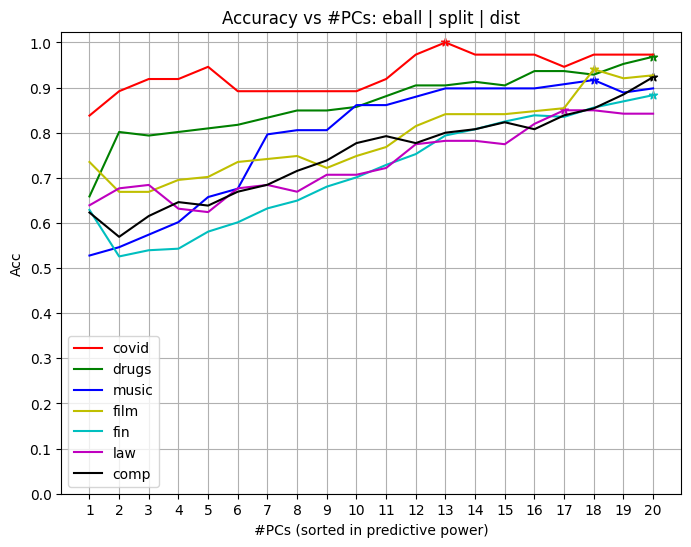

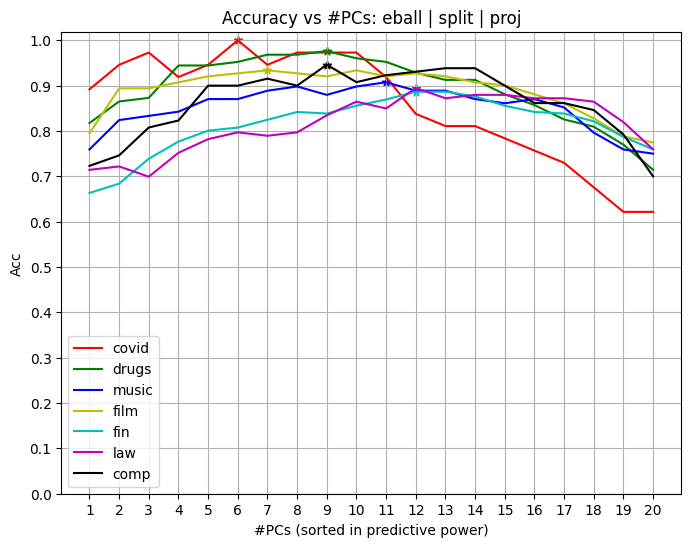

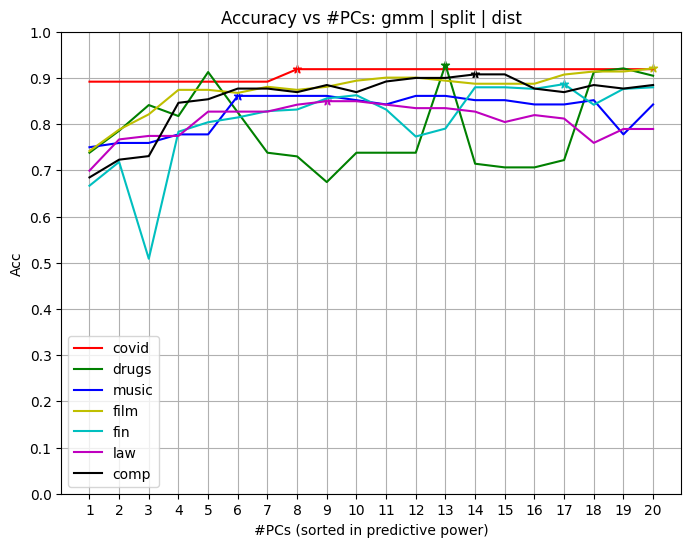

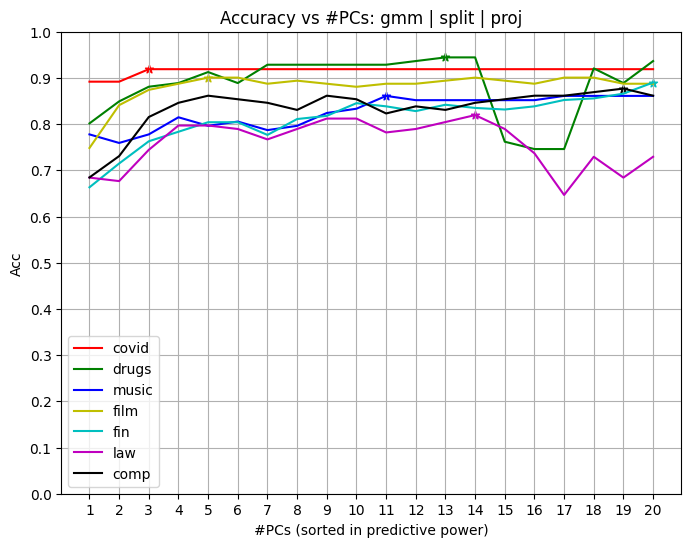

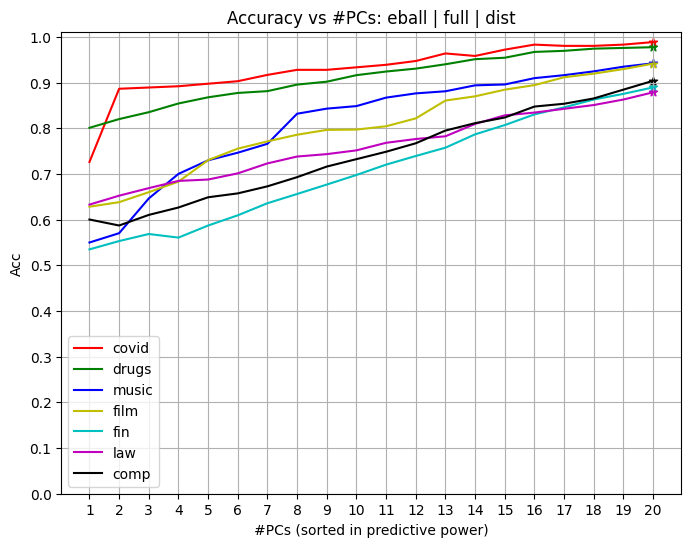

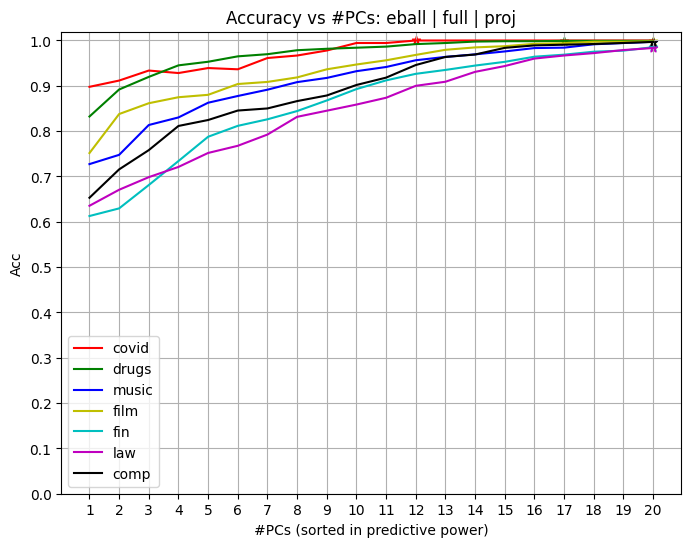

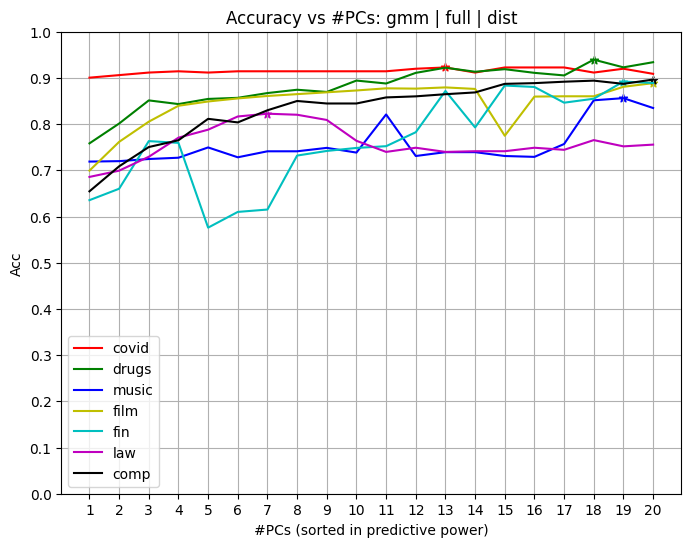

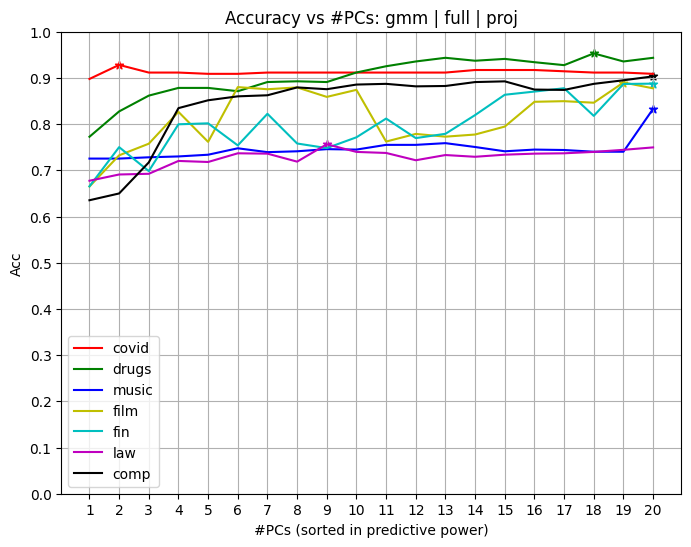

In [ ]:
# main()